In [ ]:
#  Import dat z tabulky v excelu - cesty a nactení DF

import pandas as pd
from pathlib import Path

# jednou definujete cestu a vytvoříte df
excel_path = Path(
    r"C:\Users\ijttr\OneDrive\Dokumenty\OCEŇOVÁNÍ\_IJK"
    r"\024276 - 2025 - Praha 6 - Dejvice - Hanspaulka - VILA rozdělení na BJ - Olt"
    r"\024276 - 2025.xlsx"
)
df_clusters = pd.read_excel(excel_path, sheet_name="data_byty", engine="openpyxl")

# rychlá kontrola
print(f"Načteno řádků: {df_clusters.shape[0]}, sloupců: {df_clusters.shape[1]}")



Načteno řádků: 211, sloupců: 185


C:\Users\ijttr\AppData\Roaming\Python\Python312\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\ijttr\AppData\Roaming\Python\Python312\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [ ]:
# Základní popisná statistika


# stačí jen využít již načtené df
import matplotlib.pyplot as plt

# vyberete si sloupce
cols = ["JC byty [Kč/m2]", "Plocha [m2]", "Vzdálenost [km]", "Datum podání"]

# příprava
df2 = df_clusters[cols].copy()
df2["Datum podání"] = pd.to_datetime(df2["Datum podání"], dayfirst=True, errors="coerce")
for c in ["JC byty [Kč/m2]", "Plocha [m2]", "Vzdálenost [km]"]:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")

# popisné statistiky
desc = df2[["JC byty [Kč/m2]", "Plocha [m2]", "Vzdálenost [km]"]].describe().round(2).T
print(desc)

# datumové statistiky
cnt = df2["Datum podání"].count()
mn  = df2["Datum podání"].min().strftime("%Y-%m-%d")
mx  = df2["Datum podání"].max().strftime("%Y-%m-%d")
print(f"\nDatum podání – count: {cnt}, min: {mn}, max: {mx}")



                 count       mean       std        min        25%        50%  \
JC byty [Kč/m2]  174.0  153710.68  26412.01  111607.14  131925.82  151483.59   
Plocha [m2]      174.0      73.13     28.12      21.00      53.72      64.15   
Vzdálenost [km]  174.0       1.41      0.38       0.23       1.33       1.48   

                       75%        max  
JC byty [Kč/m2]  168514.83  235732.01  
Plocha [m2]          89.60     177.30  
Vzdálenost [km]       1.48       2.59  

Datum podání – count: 174, min: 2021-08-04, max: 2025-04-04


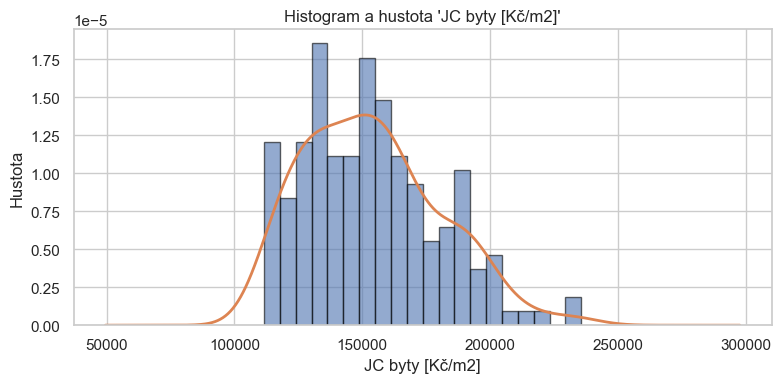

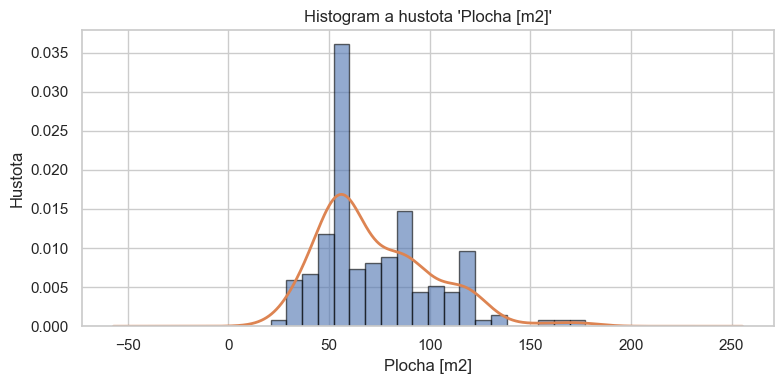

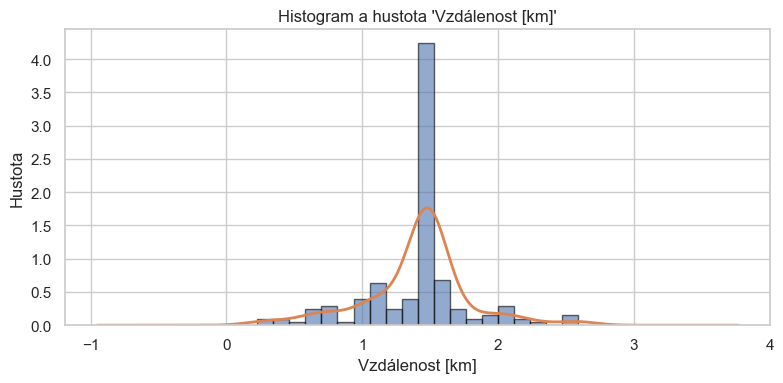

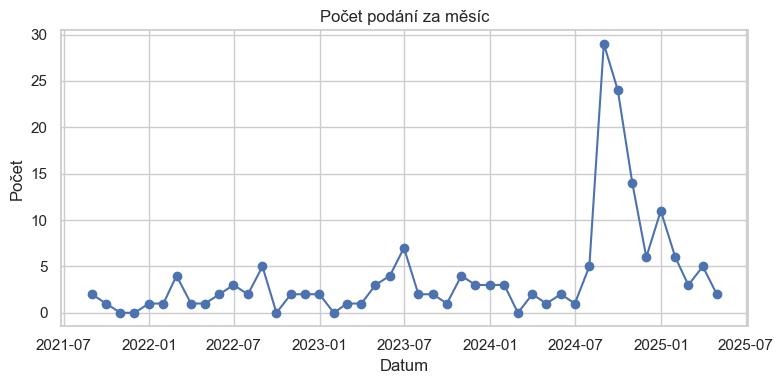

In [ ]:
# Histogramy

import numpy as np

# histogramy s hustotní křivkou
for c in ["JC byty [Kč/m2]", "Plocha [m2]", "Vzdálenost [km]"]:
    df_clusters = df2[c].dropna()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(df_clusters, bins=20, density=True, alpha=0.6, edgecolor='black')
    df_clusters.plot.kde(ax=ax, linewidth=2)
    ax.set_title(f"Histogram a hustota '{c}'")
    ax.set_xlabel(c)
    ax.set_ylabel("Hustota")
    plt.tight_layout()
    plt.show()

# časová řada počtu podání za měsíc
df_monthly = df2.set_index("Datum podání").resample("M").size()
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(df_monthly.index, df_monthly.values, marker='o')
ax.set_title("Počet podání za měsíc")
ax.set_xlabel("Datum")
ax.set_ylabel("Počet")
plt.tight_layout()
plt.show()


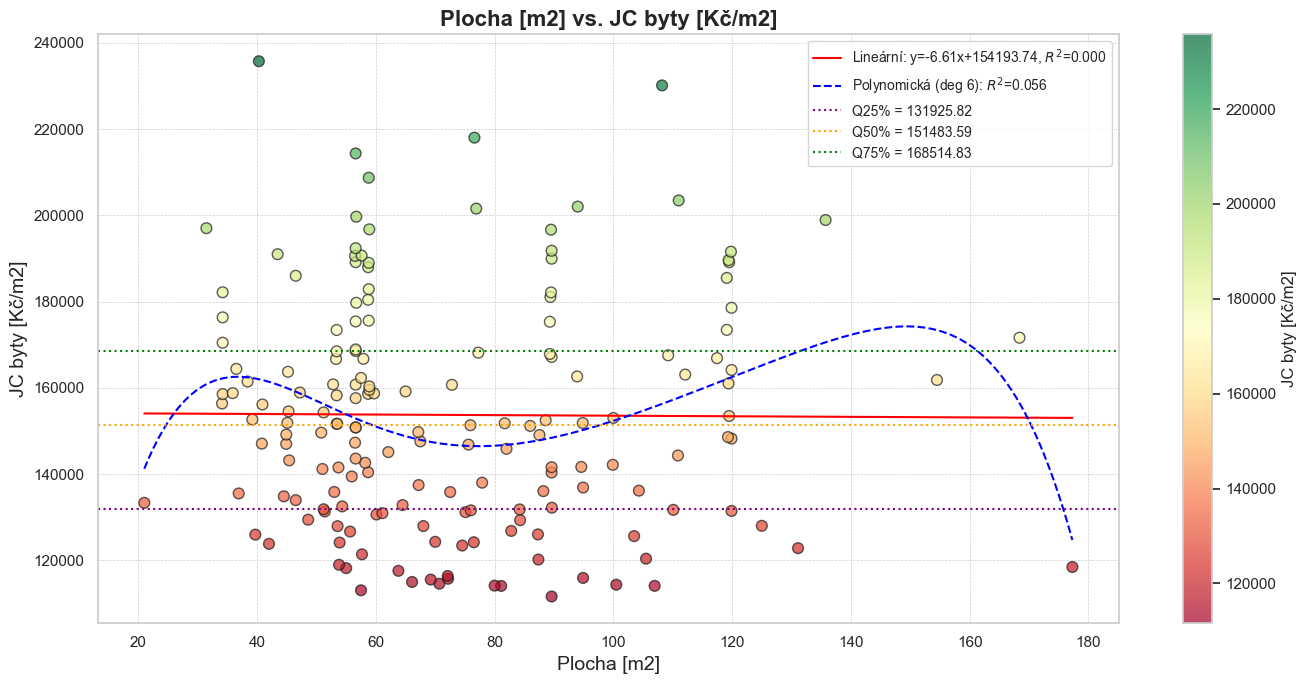

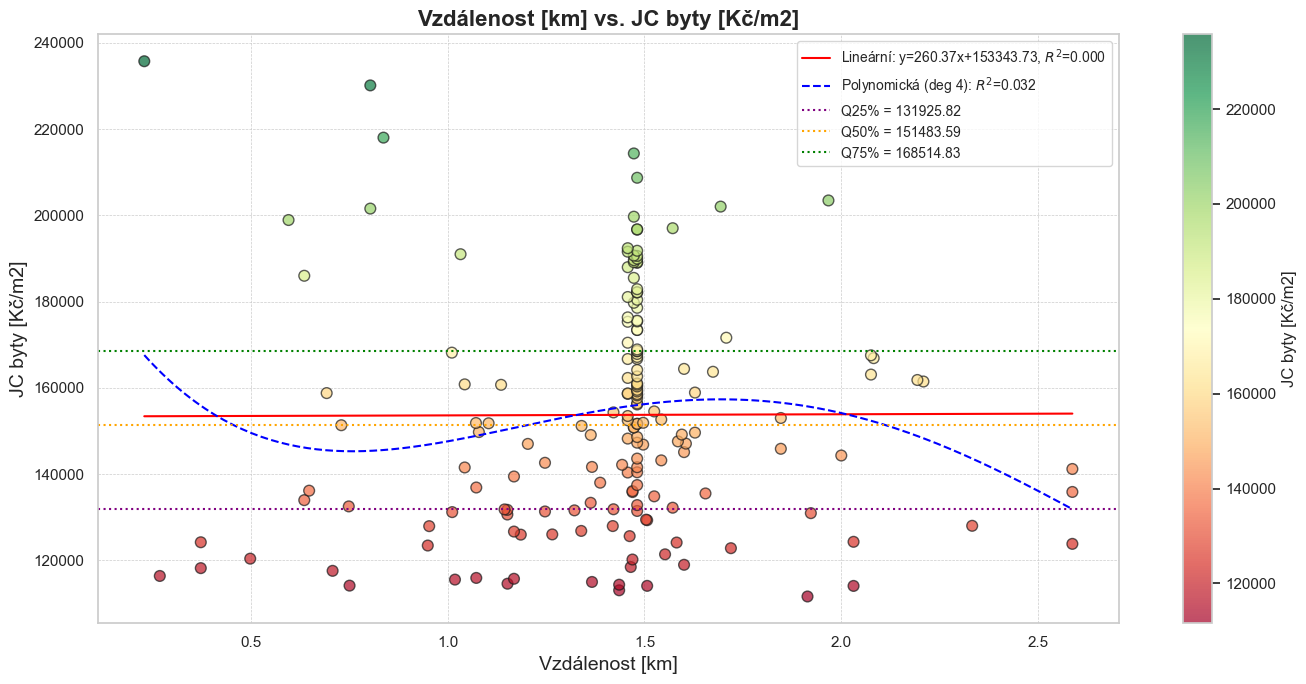

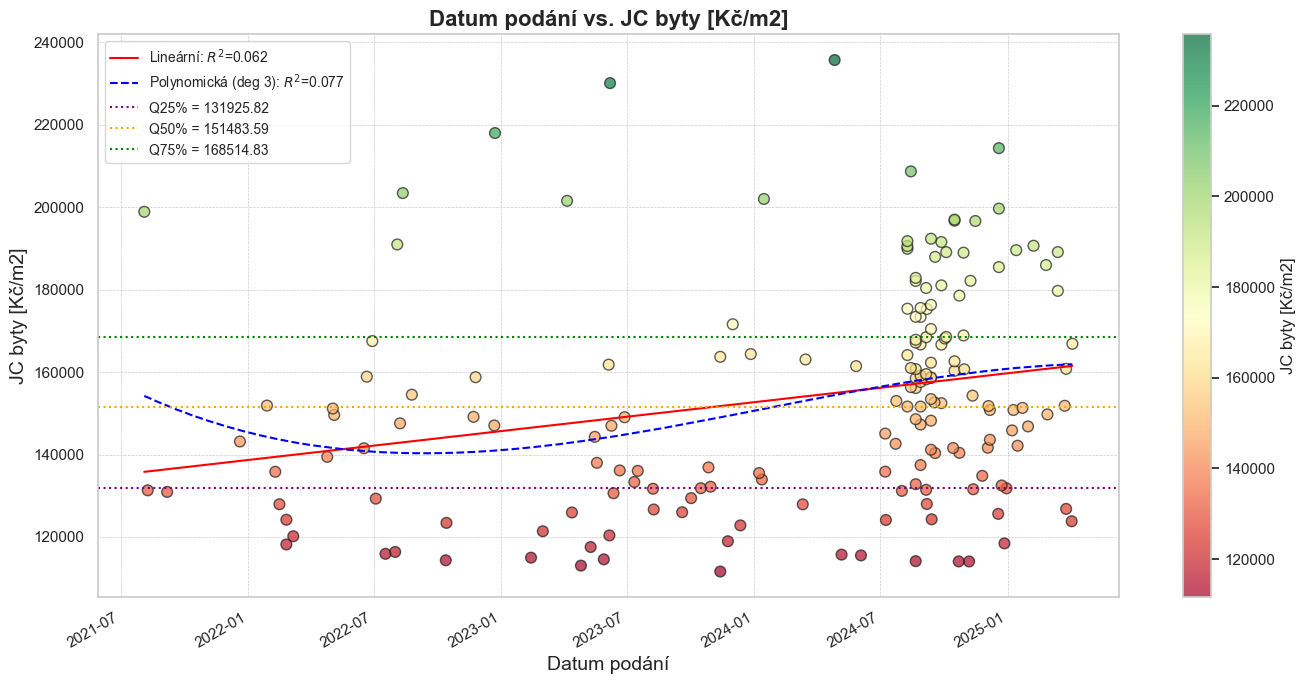

In [ ]:
# Vztahy jednotlivych paranmetrů a JC byty [Kč/m2]

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator

# Předpoklad: df již načteno dříve a obsahuje sloupce
# "Plocha [m2]", "JC byty [Kč/m2]", "Vzdálenost [km]", "Datum podání"

# Styly
palette    = plt.get_cmap("RdYlGn")
point_size = 60
alpha      = 0.7
edgecol    = 'k'
sns.set(style="whitegrid")

def plot_scatter(x, y, xlabel, ylabel, title, degree=1, show_poly=True):
    xi, yi = x.values, y.values
    mask = np.isfinite(xi) & np.isfinite(yi)
    xi, yi = xi[mask], yi[mask]
    if len(xi) < 2:
        print(f"Není dost dat pro '{title}'")
        return

    # Lineární regrese
    a, b = np.polyfit(xi, yi, 1)
    r2_lin = np.corrcoef(xi, yi)[0,1]**2

    # Polynomická regrese
    poly = None
    if show_poly and degree > 1 and len(xi) > degree:
        coef_poly = np.polyfit(xi, yi, degree)
        poly = np.poly1d(coef_poly)
        y_pred = poly(xi)
        ss_tot = ((yi - yi.mean())**2).sum()
        ss_res = ((yi - y_pred)**2).sum()
        r2_poly = 1 - ss_res/ss_tot

    xr = np.linspace(xi.min(), xi.max(), 200)
    fig, ax = plt.subplots(figsize=(14,7), dpi=100)
    sc = ax.scatter(xi, yi, c=yi, cmap=palette, s=point_size,
                    edgecolor=edgecol, alpha=alpha)

    # Vykreslit lineární křivku
    ax.plot(xr, a*xr + b, color="red",
            label=f"Lineární: y={a:.2f}x+{b:.2f}, $R^2$={r2_lin:.3f}")

    # Vykreslit polynomickou křivku
    if poly is not None:
        ax.plot(xr, poly(xr), color="blue", linestyle="--",
                label=f"Polynomická (deg {degree}): $R^2$={r2_poly:.3f}")

    # Kvartily
    Q1, Q2, Q3 = np.percentile(yi, [25,50,75])
    for q, col, pct in [(Q1,"purple","25%"), (Q2,"orange","50%"), (Q3,"green","75%")]:
        ax.axhline(q, color=col, linestyle=":", linewidth=1.5,
                   label=f"Q{pct} = {q:.2f}")

    # Colorbar a popisky
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(ylabel)
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend(loc="best", fontsize=10)
    ax.grid(linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_time_scatter(dates, values, ylabel, title, degree=1):
    mask = dates.notna() & np.isfinite(values)
    dates = dates[mask]
    y = values[mask].astype(float)
    if len(dates) < 2:
        print(f"Není dost dat pro '{title}'")
        return

    # Převod na ordinal a regrese
    x_ord = dates.map(pd.Timestamp.toordinal).values
    a, b = np.polyfit(x_ord, y, 1)
    r2_lin = np.corrcoef(x_ord, y)[0,1]**2

    poly = None
    if degree > 1 and len(dates) > degree:
        coef_poly = np.polyfit(x_ord, y, degree)
        poly = np.poly1d(coef_poly)
        y_pred = poly(x_ord)
        ss_tot = ((y - y.mean())**2).sum()
        ss_res = ((y - y_pred)**2).sum()
        r2_poly = 1 - ss_res/ss_tot

    dates_range = pd.date_range(dates.min(), dates.max(), periods=200)
    x_ord_range = dates_range.map(pd.Timestamp.toordinal).values

    fig, ax = plt.subplots(figsize=(14,7), dpi=100)
    sc = ax.scatter(dates, y, c=y, cmap=palette, s=point_size,
                    edgecolor=edgecol, alpha=alpha)

    # Lineární trend
    ax.plot(dates_range, a*x_ord_range + b, color="red",
            label=f"Lineární: $R^2$={r2_lin:.3f}")

    # Polynomický trend
    if poly is not None:
        ax.plot(dates_range, poly(x_ord_range), color="blue", linestyle="--",
                label=f"Polynomická (deg {degree}): $R^2$={r2_poly:.3f}")

    # Kvartily
    Q1, Q2, Q3 = np.percentile(y, [25,50,75])
    for q, col, pct in [(Q1,"purple","25%"), (Q2,"orange","50%"), (Q3,"green","75%")]:
        ax.axhline(q, color=col, linestyle=":", linewidth=1.5,
                   label=f"Q{pct} = {q:.2f}")

    # Formát osy X
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    fig.autofmt_xdate()

    # Colorbar a popisky
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(ylabel)
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel("Datum podání", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend(loc="best", fontsize=10)
    ax.grid(linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Vykreslení všech tří grafů
plot_scatter(
    df_clusters["Plocha [m2]"], df_clusters["JC byty [Kč/m2]"],
    xlabel="Plocha [m2]", ylabel="JC byty [Kč/m2]",
    title="Plocha [m2] vs. JC byty [Kč/m2]",
    degree=6, show_poly=True
)

plot_scatter(
    df_clusters["Vzdálenost [km]"], df_clusters["JC byty [Kč/m2]"],
    xlabel="Vzdálenost [km]", ylabel="JC byty [Kč/m2]",
    title="Vzdálenost [km] vs. JC byty [Kč/m2]",
    degree=4, show_poly=True
)

plot_time_scatter(
    df_clusters["Datum podání"], df_clusters["JC byty [Kč/m2]"],
    ylabel="JC byty [Kč/m2]",
    title="Datum podání vs. JC byty [Kč/m2]",
    degree=3
)



Optimální počet shluků K podle metody lokte: 4
Maximální vzdálenost od přímky: 2.60
Toto K značí místo, kde se při navyšování K nejméně zlepšuje SSE, tedy ideální bod lokte.



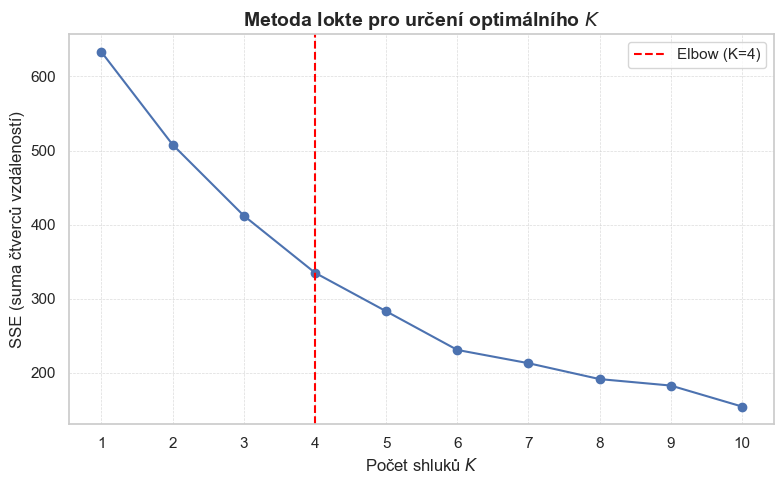

In [ ]:
# Metoda Lokte a urceni optimalniho K ... počtu shluků pro shlukovou analýzu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Předpoklad: df je již načtené z Excelu ---

# 1) Vybereme numerické sloupce
num_cols = ["Plocha [m2]", "JC byty [Kč/m2]", "Vzdálenost [km]"]

# 2) Explicitní převod na čísla
df_clusters[num_cols] = df_clusters[num_cols].apply(pd.to_numeric, errors="coerce")

# 3) Imputace chybějících hodnot průměrem
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(df_clusters[num_cols])

# 4) Škálování
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 5) Výpočet SSE pro K = 1…10
sse = []
k_range = np.arange(1, 11)
for k in k_range:
    km = KMeans(n_clusters=int(k), random_state=42)
    km.fit(X_scaled)
    sse.append(km.inertia_)

# 6) Detekce "elbow" metodou největší vzdálenosti od přímky mezi krajními body
# Souřadnice přímky
x1, y1 = k_range[0], sse[0]
x2, y2 = k_range[-1], sse[-1]
# Vzdálenosti bodů
distances = []
for x0, y0 in zip(k_range, sse):
    # vzdálenost bodu (x0,y0) od přímky (x1,y1)-(x2,y2)
    num = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(num/den)
# optimal K
optimal_idx = np.argmax(distances)
optimal_k = k_range[optimal_idx]


# 7) Výpis zdůvodnění
print(f"Optimální počet shluků K podle metody lokte: {optimal_k}")
print(f"Maximální vzdálenost od přímky: {distances[optimal_idx]:.2f}")
print("Toto K značí místo, kde se při navyšování K nejméně zlepšuje SSE, tedy ideální bod lokte.\n")

# 8) Graf metody lokte s vyznačením optimálního K
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(k_range, sse, marker='o', linestyle='-')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Elbow (K={optimal_k})')
plt.xticks(k_range)
plt.xlabel('Počet shluků $K$', fontsize=12)
plt.ylabel('SSE (suma čtverců vzdáleností)', fontsize=12)
plt.title('Metoda lokte pro určení optimálního $K$', fontsize=14, fontweight='bold')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


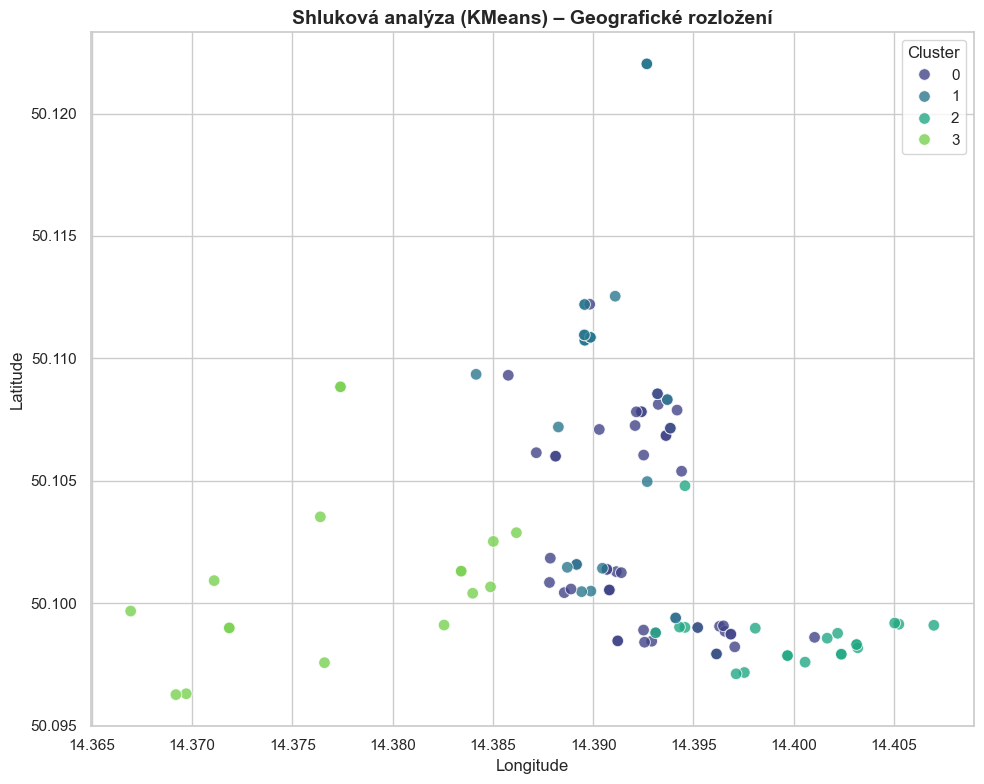

In [ ]:
# Shluková analýza

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import linregress
from matplotlib.lines import Line2D

# ——— 1) Použijte váš existující DF —–
# Zde nahraďte YOUR_DF názvem proměnné, kterou v notebooku používáte
df_clusters = df_clusters.copy()

# ——— 2) Připravíme časovou proměnnou —–
df_clusters['Datum podání'] = pd.to_datetime(
    df_clusters['Datum podání'], dayfirst=True, errors='coerce'
)
df_clusters['Datum podání (dny)'] = (
    df_clusters['Datum podání'] - df_clusters['Datum podání'].min()
).dt.days

# ——— 3) Definice vstupních sloupců —–
features = [
    'LAT', 'LON',
    'JC byty [Kč/m2]', 'Plocha [m2]',
    'Vzdálenost [km]', 'Datum podání (dny)'
]

# ——— 4) Imputace chybějících hodnot průměrem —–
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_clusters[features])

# ——— 5) Standardizace —–
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ——— 6) K-Means clustering —–
# optimal_k musí být předem definováno (např. z metody lokte)
kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=50,
    algorithm='elkan'
)
df_clusters['Cluster'] = kmeans.fit_predict(X_scaled)

# ——— 7) Výsledek: df_clusters obsahuje nový sloupec 'Cluster' —–

# ——— 8) Ukázkové vykreslení: mapa všech clusterů —–
palette = sns.color_palette(
    'viridis',
    n_colors=len(df_clusters['Cluster'].unique())
)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='LON', y='LAT',
    data=df_clusters,
    hue='Cluster', palette=palette,
    s=70, alpha=0.8
)
plt.title(
    'Shluková analýza (KMeans) – Geografické rozložení',
    fontsize=14, fontweight='bold'
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# Geografické znázornění shluků

import folium
from folium.plugins import MarkerCluster
from branca.element import Template, MacroElement
import seaborn as sns
from matplotlib import colors as mcolors
from IPython import get_ipython

# Získání DataFrame df_clusters z paměti
ns = get_ipython().user_ns
df_clusters = ns.get('df_clusters')
if df_clusters is None:
    raise ValueError("DataFrame 'df_clusters' není k dispozici. Spusťte buňku s clusteringem.")

# Připravíme barvy pro jednotlivé clustery
clusters = sorted(df_clusters['Cluster'].unique())
palette = sns.color_palette('viridis', n_colors=len(clusters))
hex_colors = [mcolors.to_hex(c) for c in palette]

# Odfiltrujeme řádky bez platných souřadnic LAT/LON
df_map = df_clusters.dropna(subset=['LAT', 'LON']).copy()

# Určíme střed mapy pro počáteční pozici
center = [df_map['LAT'].mean(), df_map['LON'].mean()]

# Sestavíme HTML pro legendu (vlevo dole)
legend_items = "".join(
    f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px;"></i>'
    f'Cluster {idx}<br>'
    for idx, color in zip(clusters, hex_colors)
)
legend_html = f"""
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 140px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
">
  <b>Legenda clusterů</b><br>
  {legend_items}
</div>
"""
# Vytvoříme MacroElement pro legendu
template = Template(f"{{% macro html(this, kwargs) %}}{legend_html}{{% endmacro %}}")
legend = MacroElement()
legend._template = template

# --- 1) Mapa s MarkerCluster ---
m_cluster = folium.Map(location=center, zoom_start=12, control_scale=True)
# Přidáme dvě vrstvy podkladových map
folium.TileLayer('OpenStreetMap',     name='OpenStreetMap').add_to(m_cluster)
folium.TileLayer('Esri.WorldImagery', name='Ortofotomap').add_to(m_cluster)

# MarkerCluster pro lepší výkon při velkém množství bodů
marker_cluster = MarkerCluster(name='Clustered').add_to(m_cluster)
for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=5,
        color=hex_colors[int(row['Cluster'])],
        fill=True,
        fill_color=hex_colors[int(row['Cluster'])],
        fill_opacity=0.8
    ).add_to(marker_cluster)

# Přidáme legendu a ovládání vrstev
m_cluster.get_root().add_child(legend)
folium.LayerControl().add_to(m_cluster)

# Zobrazíme mapu s clusterovanými markery
from IPython.display import display
display(m_cluster)

# --- 2) Mapa se všemi body barevně dle clusteru ---
m_points = folium.Map(location=center, zoom_start=12, control_scale=True)
folium.TileLayer('OpenStreetMap',     name='OpenStreetMap').add_to(m_points)
folium.TileLayer('Esri.WorldImagery', name='Ortofotomap').add_to(m_points)

for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=5,
        color=hex_colors[int(row['Cluster'])],
        fill=True,
        fill_color=hex_colors[int(row['Cluster'])],
        fill_opacity=0.9
    ).add_to(m_points)

# Přidáme legendu a ovládání vrstev
m_points.get_root().add_child(legend)
folium.LayerControl().add_to(m_points)

# Zobrazíme mapu se všemi body
display(m_points)


C:\Users\ijttr\AppData\Local\Temp\ipykernel_62976\1747876058.py:94: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(x=x, y=y, data=cd, hue='Cluster', palette=palette,
C:\Users\ijttr\AppData\Local\Temp\ipykernel_62976\1747876058.py:94: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(x=x, y=y, data=cd, hue='Cluster', palette=palette,
C:\Users\ijttr\AppData\Local\Temp\ipykernel_62976\1747876058.py:94: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(x=x, y=y, data=cd, hue='Cluster', palette=palette,
C:\Users\ijttr\AppData\Local\Temp\ipykernel_62976\1747876058.py:113: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(x='LON', y='LAT', data=cd, hue='Cluster', palette=palette,
C:\Users\ijttr\AppData\Local\Temp\ipykernel_62976\1747876058.py:94:

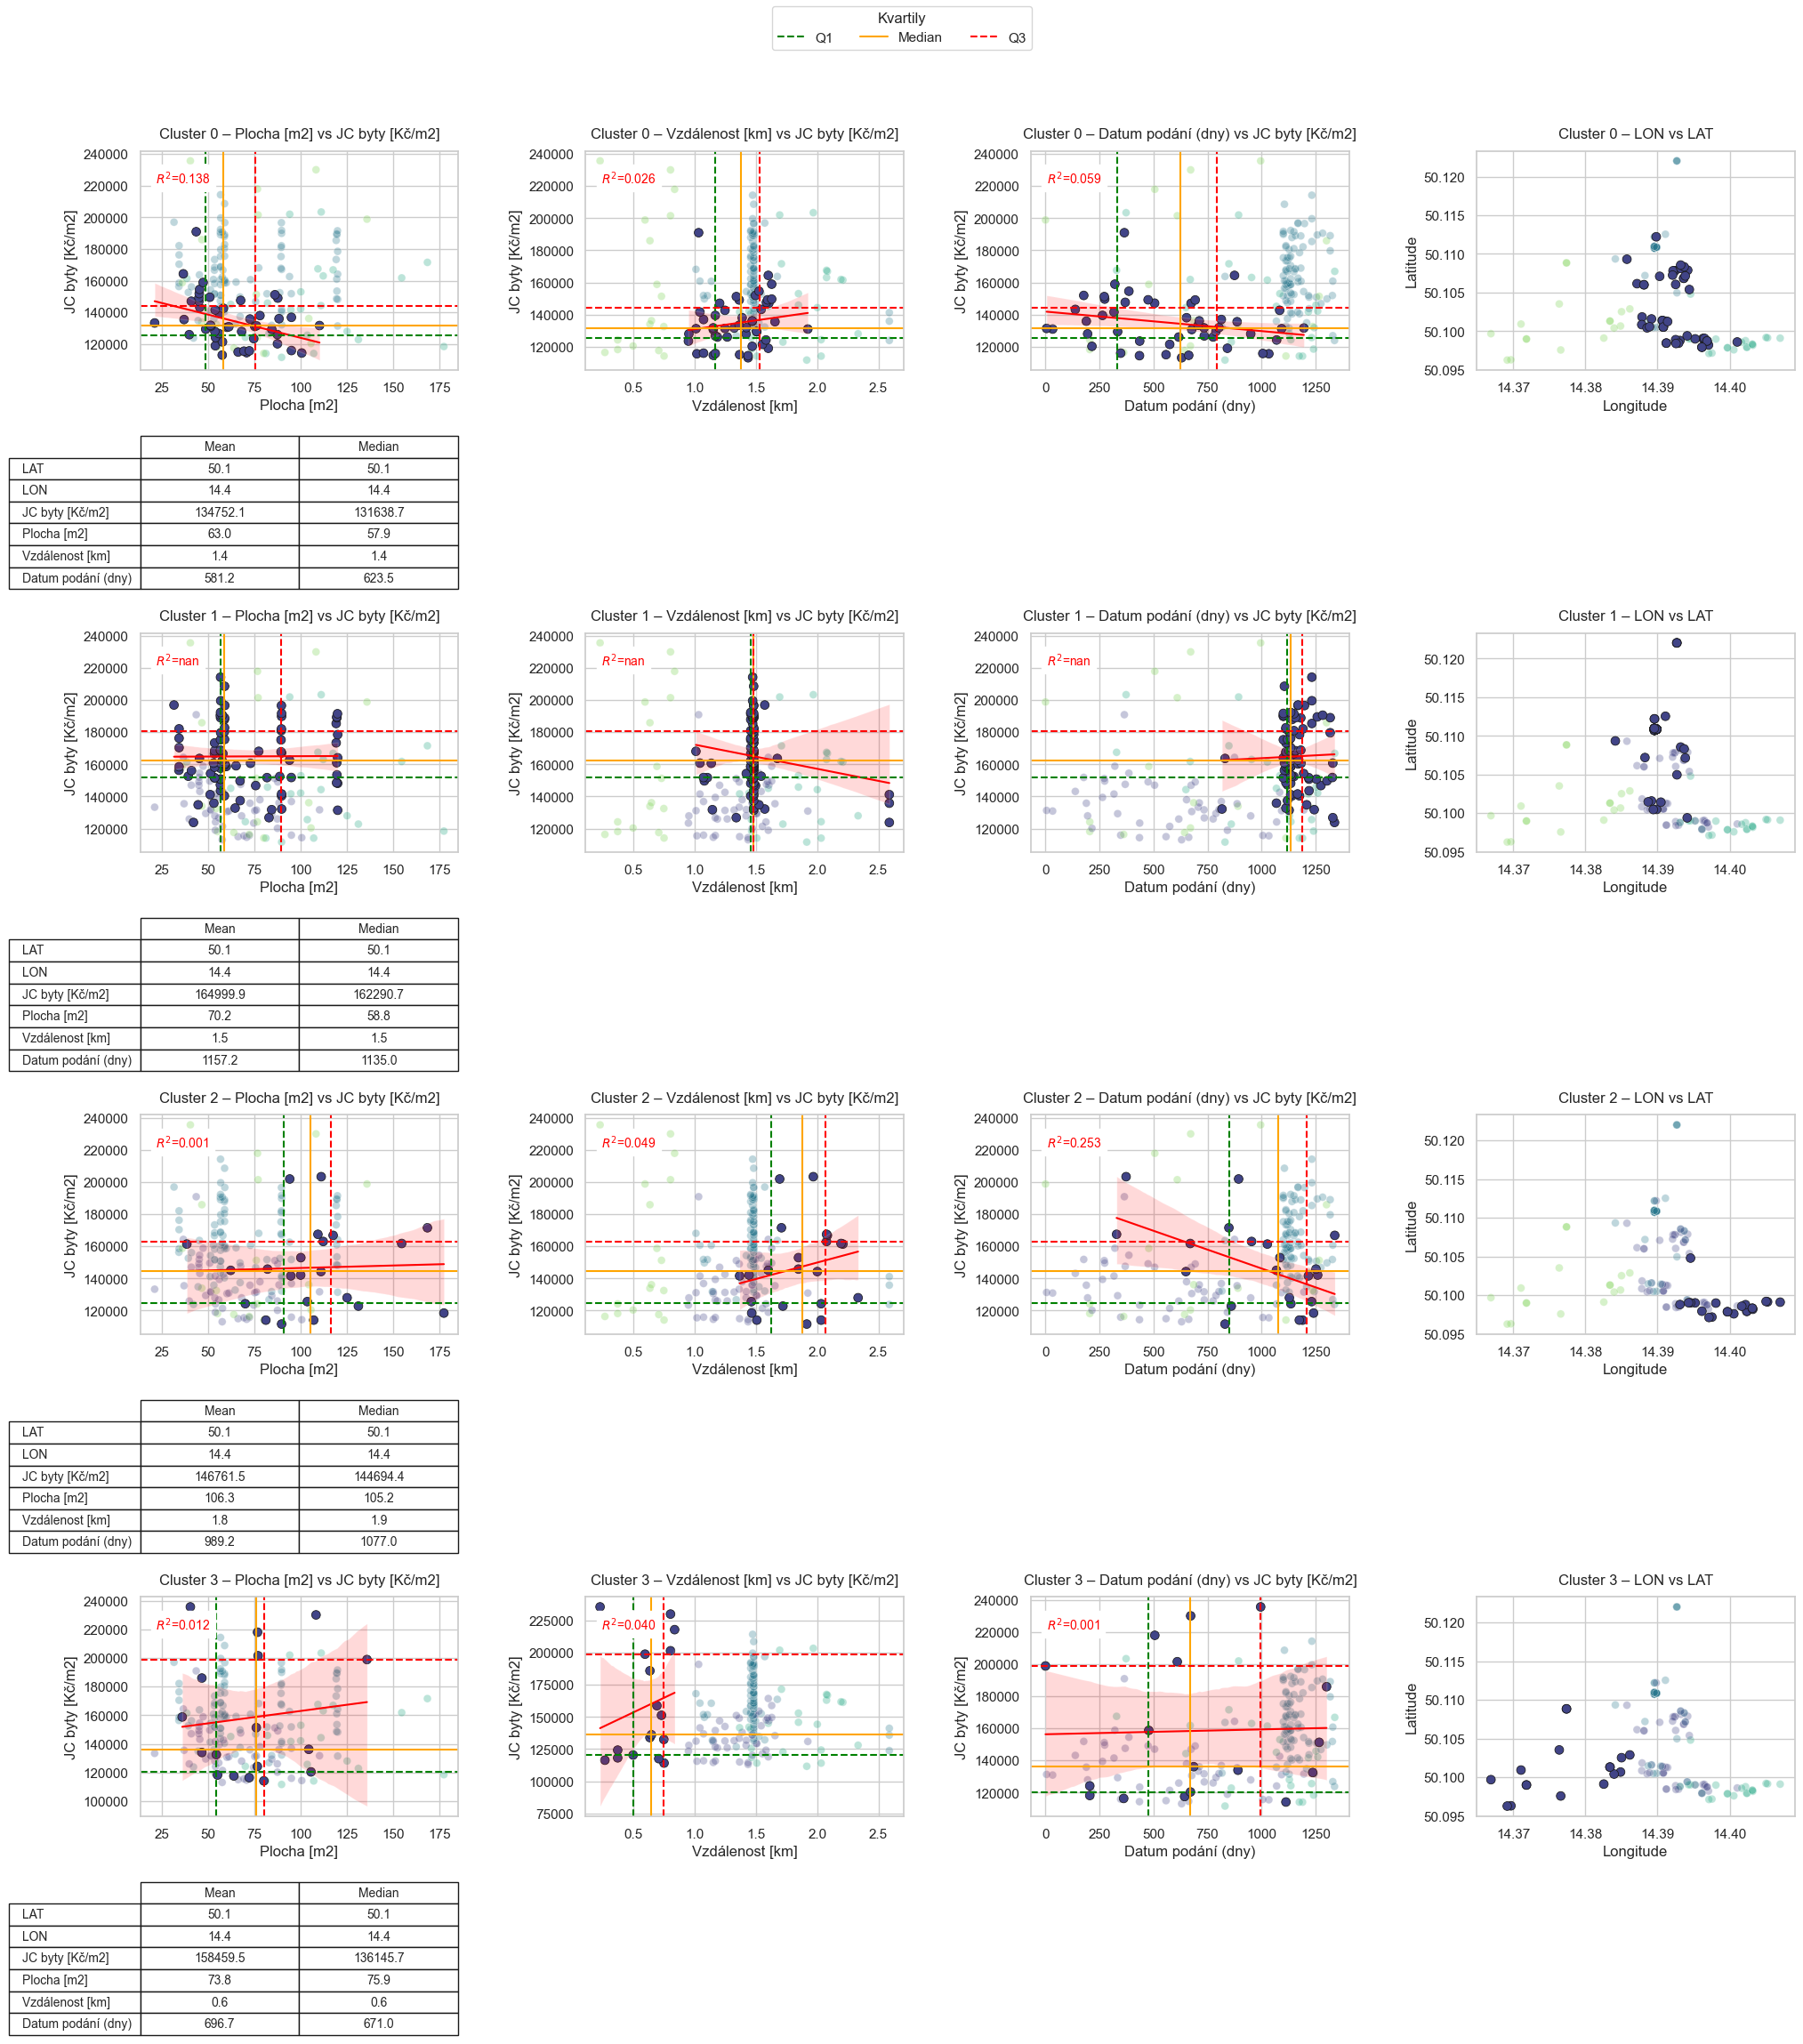

In [122]:
# Shluková a vztahová analýza


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import linregress

# --- Předpoklad: df_clusters je již načtené a obsahuje sloupce:
# 'LAT', 'LON', 'JC byty [Kč/m2]', 'Plocha [m2]', 'Vzdálenost [km]', 'Datum podání'

# 1) Převod a příprava časové proměnné
df_clusters['Datum podání'] = pd.to_datetime(
    df_clusters['Datum podání'], dayfirst=True, errors='coerce'
)
df_clusters['Datum podání (dny)'] = (
    df_clusters['Datum podání'] - df_clusters['Datum podání'].min()
).dt.days

# 2) Definice feature setu
features = [
    'LAT','LON',
    'JC byty [Kč/m2]','Plocha [m2]',
    'Vzdálenost [km]','Datum podání (dny)'
]

# 3) Imputace chybějících hodnot
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_clusters[features])

# 4) Standardizace a K-means
X_scaled = StandardScaler().fit_transform(X_imputed)
kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=50,
    algorithm='elkan'
).fit(X_scaled)
df_clusters['Cluster'] = kmeans.labels_

# 5) Paleta pro konzistentní barvy
clusters = sorted(df_clusters['Cluster'].unique())
palette = sns.color_palette('viridis', n_colors=len(clusters))

# 6) Příprava handle pro kvartily (bez samostatného vykreslení)
quartile_handles = [
    plt.Line2D([0],[0], color='green',   linestyle='--', label='Q1'),
    plt.Line2D([0],[0], color='orange',  linestyle='-',  label='Median'),
    plt.Line2D([0],[0], color='red',     linestyle='--', label='Q3'),
]

# --- 1) Celková mapa clusterů (zakomentováno, pokud nepotřebujete) ---
# plt.figure(figsize=(10,8))
# sns.scatterplot(x='LON', y='LAT', data=df_clusters,
#                 hue='Cluster', palette=palette,
#                 s=70, alpha=0.8)
# plt.title('Geografické rozložení všech clusterů', fontsize=14, fontweight='bold')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(title='Cluster', loc='upper right')
# plt.tight_layout()
# plt.show()

# --- 2) Detailní per-cluster grafy s R² a tabulkami ---
fig, axs = plt.subplots(len(clusters), 4, figsize=(24, 6*len(clusters)))
if len(clusters) == 1:
    axs = axs.reshape(1, -1)

pairs = [
    ('Plocha [m2]','JC byty [Kč/m2]'),
    ('Vzdálenost [km]','JC byty [Kč/m2]'),
    ('Datum podání (dny)','JC byty [Kč/m2]'),
    ('LON','LAT')
]

for i, cluster in enumerate(clusters):
    cd = df_clusters[df_clusters['Cluster']==cluster]
    q1 = cd[features].quantile(0.25)
    q2 = cd[features].quantile(0.50)
    q3 = cd[features].quantile(0.75)

    for j,(x,y) in enumerate(pairs):
        ax = axs[i,j]

        if j < 3:
            # pozadí všech bodů
            sns.scatterplot(x=x, y=y, data=df_clusters, hue='Cluster', palette=palette,
                            ax=ax, legend=False, alpha=0.3, s=40)
            # body aktuálního clusteru
            sns.scatterplot(x=x, y=y, data=cd, hue='Cluster', palette=palette,
                            ax=ax, legend=False, s=50, edgecolor='k')
            # lineární regrese + R²
            slope, intercept, r_value, p_value, std_err = linregress(cd[x], cd[y])
            sns.regplot(x=x, y=y, data=cd, ax=ax, scatter=False,
                        color='red', line_kws={'linewidth':1.5})
            ax.text(0.05, 0.85, f"$R^2$={r_value**2:.3f}",
                    transform=ax.transAxes, color='red',
                    fontsize=10, backgroundcolor='white')
            # kvartilové čáry
            for label, quart in zip(['Q1','Median','Q3'], [q1, q2, q3]):
                style = '--' if label != 'Median' else '-'
                color = {'Q1':'green','Median':'orange','Q3':'red'}[label]
                ax.axvline(quart[x], linestyle=style, color=color)
                ax.axhline(quart[y], linestyle=style, color=color)
        else:
            # geografický panel
            sns.scatterplot(x='LON', y='LAT', data=df_clusters, hue='Cluster', palette=palette,
                            ax=ax, legend=False, alpha=0.3, s=40)
            sns.scatterplot(x='LON', y='LAT', data=cd, hue='Cluster', palette=palette,
                            ax=ax, legend=False, s=50, edgecolor='k')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

        ax.set_title(f"Cluster {cluster} – {x} vs {y}", pad=10)

    # tabulka mean / median pod grafy
    cell_text = [[f"{cd[col].mean():.1f}", f"{cd[col].median():.1f}"] for col in features]
    axs[i,0].table(
        cellText=cell_text,
        rowLabels=features,
        colLabels=['Mean','Median'],
        loc='bottom',
        bbox=[0.0, -1.0, 1.0, 0.7],
        colWidths=[0.2,0.2],
        cellLoc='center'
    )

# 7) Přidáme legendu kvartilů společně s grafy
fig.legend(handles=quartile_handles, loc='upper center', ncol=3, title='Kvartily')
plt.subplots_adjust(hspace=1.2, wspace=0.4, bottom=0.15, top=0.93)
plt.show()
